In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import os
import cv2
import pandas as pd
import numpy as np
import random

In [10]:
import cv2
import os
import pandas as pd

# Define the base folder for your images and categories
base_folder = "images/"
categories = ['ball', 'notBall']

# Function to read and resize an image
def preprocess_image(filename, folder, size=(224, 224)):
    filepath = os.path.join(folder, filename)
    img = cv2.imread(filepath)
    img = cv2.resize(img, size)
    img = img / 255.0  # Normalize pixel values
    return img

# Process images and store the data in a list
data = []

for category in categories:
    folder = os.path.join(base_folder, category)
    for filename in os.listdir(folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            processed_img = preprocess_image(filename, folder)
            data.append({
                'filename': filename,
                'category': category,
                'processed_image': processed_img
            })

# Create a DataFrame from the list
df = pd.DataFrame(data)

df['processed_image'] = df['processed_image'].apply(np.array)

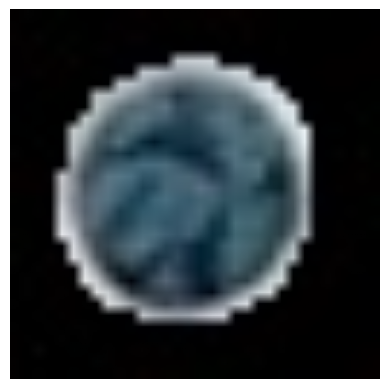

In [12]:
# Assuming 'processed_image' column contains the image data
random_idx = random.randint(0, len(df) - 1)
random_image = df.iloc[random_idx]['processed_image']


plt.imshow(random_image)
plt.axis('off')  # Turn off axis numbers/ticks
plt.show()


In [13]:
# Convert 'category' to numerical labels
encoder = LabelEncoder()
df['category'] = encoder.fit_transform(df['category'])

# Separating features and labels
X = np.array(df['processed_image'].tolist())
y = df['category'].values

In [14]:
# Load pre-trained MobileNetV2
# Modify the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

In [15]:
# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.5)(x)  # Dropout
predictions = Dense(1, activation='sigmoid')(x)

In [16]:
model = Model(inputs=base_model.input, outputs=predictions)


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)


In [20]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [21]:
# Train the model with Data Augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
9/9 [==============================] - 2s 196ms/step - loss: 10.8383 - accuracy: 0.8606 - val_loss: 9.5355 - val_accuracy: 0.8525
Epoch 2/10
9/9 [==============================] - 2s 164ms/step - loss: 8.4273 - accuracy: 0.9826 - val_loss: 7.4518 - val_accuracy: 0.9836
Epoch 3/10
9/9 [==============================] - 2s 165ms/step - loss: 6.7039 - accuracy: 0.9617 - val_loss: 5.8456 - val_accuracy: 0.9836
Epoch 4/10
9/9 [==============================] - 2s 166ms/step - loss: 5.2547 - accuracy: 0.9861 - val_loss: 4.6374 - val_accuracy: 0.9836
Epoch 5/10
9/9 [==============================] - 2s 171ms/step - loss: 4.2321 - accuracy: 0.9791 - val_loss: 3.7561 - val_accuracy: 0.9836
Epoch 6/10
9/9 [==============================] - 2s 165ms/step - loss: 3.4925 - accuracy: 0.9756 - val_loss: 3.1408 - val_accuracy: 0.9836
Epoch 7/10
9/9 [==============================] - 2s 166ms/step - loss: 2.8479 - accuracy: 0.9965 - val_loss: 2.5916 - val_accuracy: 0.9836
Epoch 8/10
9/9 [===

In [22]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 0s 95ms/step - loss: 1.5834 - accuracy: 1.0000
Test Accuracy: 1.0


In [24]:
model.save('my_model.keras')  # Save the model to disk


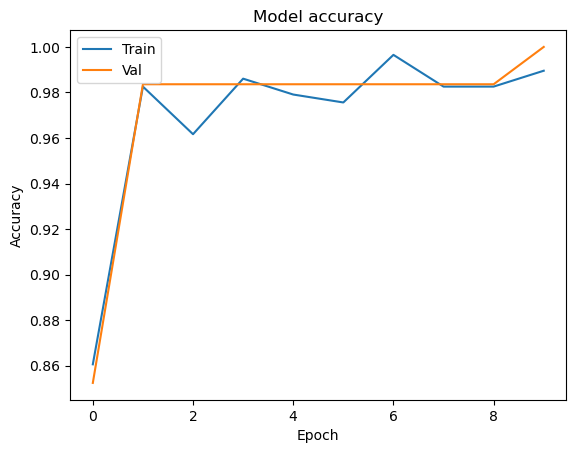

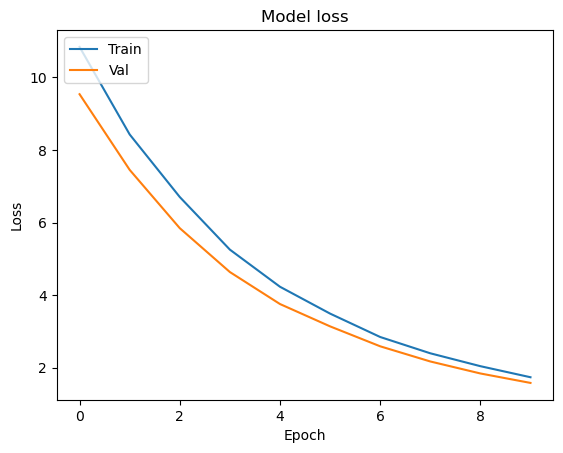

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
